<a href="https://colab.research.google.com/github/hoangdungnguyen/XVA-project/blob/master/Kamrad_Ritchken_tree_for_w.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 3.1.2 Kamrad-Ritchken tree for $w$

Now, we describe the pricing scheme for $w$. To do that, we apply Kamrad-Ritchken Trinomial Tree (KR tree for short). According to this method, there are three possible values of the underlying $S$ at the next stage: Up, Middle and Down with the multipliers $U, M, D$ respectively. As a consequence, KR tree will have $2 N+1$ terminal underlying values at the maturity. The probability of each stage and Kamrad-Ritchken
parameters as following:
$$
\begin{array}{l}
U=e^{a \sigma \sqrt{\Delta t}} \quad p_{+}=\frac{1}{2 a^{2}}+\frac{b \sqrt{\Delta t}}{2 a \sigma} \\
M=1 \quad \quad p=1-\frac{1}{a^{2}} \\
D=e^{-a \sigma \sqrt{\Delta t}} \quad p_{-}=\frac{1}{2 a^{2}} -\frac{b \sqrt{\Delta t}}{\sqrt{2 a \sigma}}
\end{array}
$$

where $a=1.22474$ (a good choice for pricing an at-themoney call or put) is a free parameter of the geometry of the tree and $b=\kappa-\frac{1}{2}\sigma^2$ We denote $(.)_{i}^{(k)}$ the value at time $t_{i}$ and state $k$ (the parenthesis of $k$ are to distinguish with the mesh simulation in the pricing of $v$ ). The 3 possibles corresponding value at the next time step $t_{i+1}$ could be (.) $_{i+1}^{(k+1)} ;(.)_{i+1}^{(k)} ;(.)_{i+1}^{(k-1)}$ for respectively up, middle and down scenarios.

The PDE of $w$ is discritized:
$$
\frac{w_{i+1}^{(k)}-w_{i}^{(k)}}{\Delta_{t}}+\kappa S_{i}^{k}
\frac{w_{i+1}^{(k+1)}-w_{i+1}^{(k-1)}}{2 \Delta_{S}}
+\frac{1}{2} \sigma^{2}\left(S_{i}^{k}\right)^{2} \frac{w_{i+1}^{(k+1)}-2 w_{i+1}^{(k)}+w_{i+1}^{(k-1)}}{\Delta_{{S}^{2}}}+h\max \left( \alpha f \sigma S_{i}^{(k)}\left|\frac{v_{i+1}^{(k+1)}-v_{i+1}^{(k-1)}}{2 \Delta_{S}} + \frac{\left(u_{b s}\right)_{i+1}^{(k+1)}-\left(u_{b s}\right)_{i+1}^{(k-1)}}{2 \Delta_{S}} \right|, w_{i}^{(k)}\right) - (r+h)w_i^{(k)}
$$
With the KR tree 's setup, we admit some results below (that can be shown by the change of variable $y=\log S$ )

$$\frac{\kappa S \Delta_{t}}{2 \Delta_{S}}=\frac{b \sqrt{\Delta_{t}}}{2 a \sigma} \quad \text { and } \quad \frac{\sigma^{2} S^{2} \Delta_{t}}{2 \Delta_{S^{2}}}=\frac{1}{2 a^{2}}$$

Then we deduct:
\begin{align}
(1 + (r + h) \Delta_t) w_i^{(k)} &= \underbrace{p_+ w_{i+1}^{(k+1)} + p w_{i+1}^{(k)} + p_- w_{i+1}^{(k-1)}}_{w\_part^{(k)}_{i+1}} +\\
&+ h \max\left( \underbrace{\alpha f \sigma \left| \frac{b\sqrt{\Delta_t}}{2\kappa a \sigma}\left(v_{i+1}^{(k+1)}-v_{i+1}^{(k-1)} + (u_{b s})_{i+1}^{(k+1)}-\left(u_{b s}\right)_{i+1}^{(k-1)}\right)\right|}_{d_{i+1}^{(k)}}, w_{i}^{(k)}\right)
\end{align}

Note $\beta^{(r+h)} = \frac{1}{1 + (r + h) \Delta_t}$, the solution of the above pricing formula takes 2 possible values with the following conditions:

\begin{equation}
\left\lbrace
  \begin{aligned}
      &w_i^{(k)} = \frac{\beta^{(r+h)} w\_part^{(k)}_{i+1}}{1 - \beta^{(r+h)}h\Delta t} \hspace{3.cm} \mbox{if} \hspace{0.3cm} d^{(k)}_{i+1} < \frac{\beta^{(r+h)} w\_part^{(k)}_{i+1}}{1 - \beta^{(r+h)}h\Delta_t}\\
    &w_i^{(k)} = \beta^{(r+h)} \Big[ w\_part^{(k)}_{i+1} + \Delta_t h d^{(k)}_{i+1} \Big] \hspace{0.3cm} \mbox{otherwise}\\
  \end{aligned}
\right.
\end{equation}

In this schema, the term $u_{bs}$ will be updated by tree probabilites while the term $v$ will be estimated by the regressor in the pricing of $v$, for example $v_{i} = f_{i}(S_i^{(k)})$.

In [1]:
%tensorflow_version 1.x

import matplotlib.pyplot as plt

%matplotlib inline

import numpy as np
import time
import timeit
import scipy as si
from scipy.stats import norm
import pandas as pd
import tensorflow as tf


TensorFlow 1.x selected.


In [50]:
r-0.2**2/2

-3.469446951953614e-18

In [0]:
### Setup
S0 = 100
r = 0.02
q = 0
sigma = 0.2
h = 0.1
lamb = 0.02

omega = np.array([3., 2., -2., 1., -1.])
K = np.array([110., 115., 120., 125., 130.])
T = np.array([1., 2., 3., 4., 5.],dtype= float)

alpha = np.linspace(0., 1., 11)

### 
nb_step = 12*5 # it must be a multiple of 5
time_step = T[-1] / nb_step
nb_path = 20000

In [0]:
class path_generator :

    def __init__(self, S0 = S0, T = 5., r = r, q = q, sigma = sigma, nb_step = nb_step):
        self.S0 = S0,
        self.T = T
        self.b = r-q
        self.sigma = sigma
        self.nb_step = nb_step
        self.time_step = T/nb_step
        self.time_path = np.linspace(0., T, self.nb_step+1, dtype=np.float64)
    def path_generate(self, nb_simulation = nb_path, random_seed = None) :

        tf.reset_default_graph()

        W_path = tf.math.cumsum(
            tf.concat([tf.zeros([nb_simulation,1], tf.float64),
                       tf.sqrt(tf.constant(self.time_step, tf.float64))*tf.random.normal([nb_simulation, self.nb_step], dtype=tf.float64, seed = random_seed)],axis = 1)
            , axis = 1)
        
        S_path = self.S0 * tf.exp((self.b- self.sigma**2/2 )*self.time_path +
                                       self.sigma *W_path)
        with tf.Session() as sess:
            self.W_path = sess.run(W_path)
            self.S_path = sess.run(S_path,{W_path:self.W_path})
             

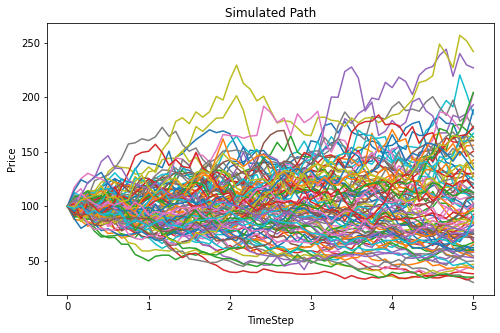

In [4]:
test = path_generator(nb_step = nb_step)
test.path_generate(100)

plt.figure(figsize=(8,5))
plt.plot(test.time_path,np.transpose(test.S_path[:,0:100]))
plt.title('Simulated Path')
plt.ylabel('Price')
plt.xlabel('TimeStep') 
plt.show()

In [0]:
def portfolio_BSprice(K = K, omega = omega, T = T, sigma = sigma, r = r, q = q,  S0 = S0):
    b = r-q
    vol = sigma*np.sqrt(T)
    d1 = (np.log(S0/K) + (b + sigma**2/2)*T)/vol 
    d2 = d1 - vol
    return (omega * (S0 * norm.cdf(d1) - K * np.exp(- r*T) * norm.cdf(d2))).sum()

In [6]:
portfolio_BSprice()

10.165504176502026

In [0]:
def poly_creator(X, degree_poly) :
    # [1 X X^2 X^3 ...]
    X_matrix = tf.reshape(tf.pow(X,0), (-1,1))
    for i in range(1, degree_poly+1):
        X_matrix = tf.concat([X_matrix, tf.reshape(tf.pow(X,i), (-1,1))], axis = 1)
    return X_matrix 

def Tree_trans(previousIterValues , kernel):
    # Reshape kernel
    kernel = tf.reshape(kernel, [2,1,1])
    # Reshape values to transfrom an array a tensor of rank 3 of shape (1,NValues,1)
    previousValue = tf.reshape(previousIterValues, [1,-1,1])
    # Apply one dimensional convolution (tf.nn.conv1d) and flatten the array
    nextValue = tf.reshape(tf.nn.conv1d(previousValue, kernel, [1,1,1], 'VALID', name = "Transition"),[-1])

    return nextValue

In [0]:
def poly_creator(X, degree_poly) :
    # [1 X X^2 X^3 ...]
    X_matrix = tf.reshape(tf.pow(X,0), (-1,1))
    for i in range(1, degree_poly+1):
        X_matrix = tf.concat([X_matrix, tf.reshape(tf.pow(X,i), (-1,1))], axis = 1)
    return X_matrix 

def Tree_trans(previousIterValues , kernel):
    # Reshape kernel
    kernel = tf.reshape(kernel, [3,1,1])
    # Reshape values to transfrom an array a tensor of rank 3 of shape (1,NValues,1)
    previousValue = tf.reshape(previousIterValues, [1,-1,1])
    # Apply one dimensional convolution (tf.nn.conv1d) and flatten the array
    nextValue = tf.reshape(tf.nn.conv1d(previousValue, kernel, [1,1,1], 'VALID', name = "Transition"),[-1])

    return nextValue

In [0]:
def first_couple_graph_generator(degree_poly = 5, nb_step = nb_step, nb_call = len(T)) :
    g = tf.Graph()
    with g.as_default():
        
        alpha = tf.placeholder(tf.float64, shape = tuple(), name = 'alpha')
        lamb = tf.placeholder(tf.float64, shape = tuple(), name = 'lamb')
        sigma = tf.placeholder(tf.float64, shape = tuple(), name = 'sigma')
        r = tf.placeholder(tf.float64, shape = tuple(), name = 'r')
        h = tf.placeholder(tf.float64, shape = tuple(), name = 'h')

        T = tf.placeholder(tf.float64, name = 'T')
        omega = tf.placeholder(tf.float64,  name = 'omega')
        K = tf.placeholder(tf.float64, name = 'K')
        ubs_0 = tf.placeholder(tf.float64, shape = tuple(), name = 'ubs_0')
        
        time_path = tf.placeholder(tf.float64, name = 'time_path')
        time_step = T[-1] / nb_step
        beta =  1/(1+r*time_step)

        # f could be a variable
        f = tf.get_variable('f', dtype=tf.float64,
                            initializer=tf.constant(1, dtype= tf.float64))
        
        ########## Setup for v1 ##########
        S_path = tf.placeholder(tf.float64, shape = (None, nb_step+1), name = 'S_path')
        W_path = tf.placeholder(tf.float64, shape = (None, nb_step+1), name = 'W_path')
        S0 = S_path[0,0]
        
        # Some calculations at the maturity that can be directly realized
        ubs = tf.zeros_like(S_path[:,-1:])
        delta_bs = tf.zeros_like(ubs)
        for n in range(nb_call) :
            ubs += tf.cast(tf.equal(T[n], time_path[-1]), tf.float64)*omega[n] * tf.maximum(S_path[:,-1:] - K[n], 0.)               
            delta_bs += tf.cast(tf.equal(T[n], time_path[-1]), tf.float64)*omega[n]*tf.cast(S_path[:,-1:] >= K[n], tf.float64)
        
        v = tf.zeros_like(S_path[:,-1:], tf.float64)
        delta_v = tf.zeros_like(S_path[:,-1:], tf.float64)
        c = lamb* tf.maximum(-alpha*f*sigma*S_path[:,-1:]*tf.abs(delta_v + delta_bs) - v + ubs ,0)

        ########## Setup for w ##########
        b = r - 0.5*sigma**2
        a = tf.placeholder(tf.float64, shape = tuple(), name = 'a')
        space_step_tree = a * sigma * tf.sqrt(time_step)

        beta_rh = 1/(1+(r+h)*time_step)
        # 3 probabilities
        pUp = 1/(2.*a**2) + b*tf.sqrt(time_step)/ (2.*a*sigma)
        p = 1 - 1/a**2
        pDown = 1/(2.*a**2) - b*tf.sqrt(time_step)/ (2.*a*sigma)

        # w = 0, v_tree = 0 at the maturity
        w = tf.zeros((2*nb_step+1), dtype = tf.float64)
        v_tree = tf.zeros((2*nb_step+1), dtype = tf.float64)
        # S_path by tree model at the maturity
        S_path_tree = S_path[0,0]* tf.exp(space_step_tree * tf.linspace(-tf.cast(nb_step,tf.float64), tf.cast(nb_step,tf.float64), num=2*nb_step + 1))

        # ubs_tree at the maturity
        ubs_tree = tf.zeros_like(S_path_tree)
        for n in range(nb_call) :
            ubs_tree += tf.cast(tf.equal(T[n], time_path[-1]), tf.float64)*omega[n] * tf.maximum(S_path_tree - K[n], 0.) 

        # Use convolution layer to update w, ubs_tree, ...
        kernel_p = tf.stack([pDown, p, pUp], axis = 0)
        kernel_minus_0_plus = tf.constant([-1., 0., 1.], dtype = tf.float64)
   
        ########## Backward for v1 and w at the same time ##########
        for i in range(nb_step-1, 0, -1) :

            ##### Update v1 #####
            X = poly_creator(S_path[:,i:(i+1)], degree_poly) # (None, 6) matrix (with bias)
            # Regressor delta_v : S -> poly_creator(S) -> v*(W - W_)
            Y = v*(W_path[:,(i+1):(i+2)] - W_path[:,i:(i+1)])
            W_delta_v = tf.linalg.lstsq(X, Y)
            delta_v = tf.matmul(X, W_delta_v)/ (sigma*time_step*S_path[:,i:(i+1)])

            # Regressor v from next step : S -> poly_creator(S) -> v + delta_time*c 
            Y = v + time_step*c            
            W_v = tf.linalg.lstsq(X, Y)
            v = beta*tf.matmul(X, W_v)
            
            # Regressor delta_bs : S -> poly_creator(S) -> ubs*(W - W_)
            Y = ubs*(W_path[:,(i+1):(i+2)] - W_path[:,i:(i+1)])
            W_delta_bs = tf.linalg.lstsq(X, Y)
            delta_bs = tf.matmul(X, W_delta_bs)/ (sigma*time_step*S_path[:,i:(i+1)])

            # Regressor ubs : S -> poly_creator(S) -> ubs
            Y = ubs
            W_ubs = tf.linalg.lstsq(X, Y)
            ubs = beta*tf.matmul(X, W_ubs)
            for n in range(nb_call) :
                ubs += tf.cast(tf.equal(T[n], time_path[i]), tf.float64)*omega[n] * tf.maximum(S_path[:,i:(i+1)] - K[n], 0.) 

            # Update c
            c = lamb * tf.maximum(-alpha*f*sigma*S_path[:,i:(i+1)]*tf.abs(delta_v + delta_bs) - v + ubs,0)

            ##### Update w #####
            w_part = Tree_trans(w, kernel_p) 
            
            first_max_part = alpha*f*sigma*tf.abs(b/tf.sqrt(time_step)/(2*r*a*sigma)*
                                    (Tree_trans(v_tree, kernel_minus_0_plus) + Tree_trans(ubs_tree, kernel_minus_0_plus)))
            w = beta_rh*((w_part + h*first_max_part*time_step)*tf.cast(first_max_part>=(beta_rh/(1-beta_rh*h*time_step)*w_part), tf.float64)+
                         w_part/(1-beta_rh*h*time_step)*tf.cast(first_max_part<(beta_rh/(1-beta_rh*h*time_step)*w_part), tf.float64))
             
            # Update S_path for tree
            S_path_tree = S0* tf.exp(space_step_tree * np.linspace(-i, i, num=2*i + 1))

            # Update ubs_tree by tree proba, attention to new payoff
            ubs_tree = beta*Tree_trans(ubs_tree, kernel_p)
            # check whether T_i is the maturity of some calls, if yes, add their payoff into ubs_tree
            for n in range(nb_call) :
                ubs_tree += tf.cast(tf.equal(T[n], time_path[i]), tf.float64)*omega[n] * tf.maximum(S_path_tree - K[n], 0.)
            
            # Update delta_v_tree, v_tree by S_path_tree and the corresponding regressors in the calcul of v
            delta_v_tree = Tree_trans(v_tree, kernel_minus_0_plus)
            X = poly_creator(tf.reshape(S_path_tree,[-1,1]), degree_poly)
            v_tree = tf.reshape(beta*tf.matmul(X,W_v),[-1])

        # Calculate v_0 by taking the mean of the discounted v_1 + delta_t*c_1
        v = tf.reduce_mean(beta*(v[:,0] + time_step*c[:,0]), name = 'v_0')

        # Calculate w_0 one more time by the recursive update
        w_part = Tree_trans(w, kernel_p)
        first_max_part = alpha*f*sigma*tf.abs(b/tf.sqrt(time_step)/(2*r*a*sigma)*
                                    (Tree_trans(v_tree, kernel_minus_0_plus) + Tree_trans(ubs_tree, kernel_minus_0_plus)))
        w = beta_rh*((w_part + h*first_max_part*time_step)*tf.cast(first_max_part>=(beta_rh/(1-beta_rh*h*time_step)*w_part), tf.float64)+
                      w_part/(1-beta_rh*h*time_step)*tf.cast(first_max_part<(beta_rh/(1-beta_rh*h*time_step)*w_part), tf.float64))
        
        w = tf.reduce_mean(w, name= 'w_0')
        # Define a loss for finding f
        loss_f = tf.identity(tf.square(w - 0.3*ubs_0), 'loss_f')
        gradient_step = tf.train.AdamOptimizer(0.1).minimize(loss_f, var_list = f, name='gradient_step')

    return g

In [0]:
def first_couple_calculator(g, S0 = S0, r = r, q = q, sigma = sigma,
                            omega = omega, K = K, T = T, 
                            alpha = alpha, h = h, lamb = lamb, f = None,
                            nb_step = nb_step, nb_path = nb_path,
                            eps = 10e-8, max_iter = 100, verbose = 10):
    # Sort calls by maturity
    ind = T.argsort()
    T = T[ind]
    omega = omega[ind]
    K = K[ind]

    # placeholder
    a = g.get_tensor_by_name('a:0')
    alpha_ = g.get_tensor_by_name('alpha:0')
    lamb_ = g.get_tensor_by_name('lamb:0')
    sigma_ = g.get_tensor_by_name('sigma:0')
    r_ = g.get_tensor_by_name('r:0')
    h_ = g.get_tensor_by_name('h:0')

    T_ = g.get_tensor_by_name('T:0')
    omega_ = g.get_tensor_by_name('omega:0')
    K_ = g.get_tensor_by_name('K:0')
    ubs_0_ = g.get_tensor_by_name('ubs_0:0')

    time_path_ = g.get_tensor_by_name('time_path:0')
    S_path_ = g.get_tensor_by_name('S_path:0')
    W_path_ = g.get_tensor_by_name('W_path:0')
        
    # gradient
    f_ = g.get_tensor_by_name('f:0')
    gradient_step = g.get_operation_by_name('gradient_step')
    loss_f = g.get_tensor_by_name('loss_f:0')

    # output
    v0 = g.get_tensor_by_name('v_0:0')
    w0 = g.get_tensor_by_name('w_0:0')
    
    # generate paths
    generator = path_generator(S0 = S0, T = T.max(), r = r, q = q, 
                               sigma = sigma, nb_step = nb_step)
    generator.path_generate(nb_path)

    feed_dict = {k:v for k,v in zip([a, alpha_, lamb_, sigma_, r_, h_, T_, omega_, K_, ubs_0_, 
                                     time_path_, S_path_, W_path_],
                                    [1.22474, alpha, lamb, sigma, r, h, T, omega, K, portfolio_BSprice(K = K, omega = omega, T = T, sigma = sigma, r = r, q = q,  S0 = S0), 
                                     generator.time_path, generator.S_path, generator.W_path])}

    with tf.Session(graph=g) as sess:
        sess.run(tf.global_variables_initializer())
        if f == None:
            err, best_err = np.inf, np.inf
            i = 0
            while (i <= max_iter):                
                sess.run(gradient_step, feed_dict=feed_dict)
                err = sess.run(loss_f, feed_dict=feed_dict)
                if verbose != None :
                    if i % verbose == 0:
                        print('iter = {:3} | err = {:.4f}'.format(i, err))
                i += 1
                if err < best_err:
                    best_err =err
                    f_fitted = sess.run(f_)
            print('Fitted f = {0:5.4f}'.format(f_fitted))
            feed_dict.update({f_:float(f_fitted)})  
        else:
            feed_dict.update({f_:f})

        v0_fitted, w0_fitted = sess.run([v0, w0], feed_dict)
        if f == None: 
            return v0_fitted, w0_fitted, f_fitted
        else:
            return v0_fitted, w0_fitted

In [20]:
p1 = time.time()
first_couple_graph = first_couple_graph_generator(degree_poly = 5, nb_step = 5)
print('First couple graph time_step = {}, setup time: {:.4f}'.format(5,time.time() - p1))

First couple graph time_step = 5, setup time: 3.2699


In [12]:
%%time
first_couple_calculator(first_couple_graph, nb_step= 5,
              sigma = 0.3, f = 1.2, alpha = 1.0, 
              omega = np.array([0., 0., 0., 0., 1.]),
              K = np.array([110., 115., 120., 125., 107.]),
              verbose = 20)

CPU times: user 1.66 s, sys: 588 ms, total: 2.25 s
Wall time: 9.07 s


(0.5447203991355017, 11.302069507773586)

In [13]:
FVA_test = []
KVA_test = []

p1 = time.time()
for alpha_ in alpha : 
    v,w = first_couple_calculator(first_couple_graph, nb_step= 5,
              sigma = 0.3, f = 1.2, alpha = alpha_, 
              omega = np.array([0., 0., 0., 0., 1.]),
              K = np.array([110., 115., 120., 125., 107.]),
              verbose = 5)
    FVA_test.append(v)
    KVA_test.append(w)
    print('alpha = {:.2f} | FVA = {:.5f} | KVA = {:.5f}'.format(alpha_,v,w))
    
print('Total time with {} paths | {} time steps | {:.2f} alphas | {:.4f} s'.format(nb_path, 5, len(alpha), time.time()-p1))

alpha = 0.00 | FVA = 2.64540 | KVA = 0.00000
alpha = 0.10 | FVA = 2.40418 | KVA = 1.15954
alpha = 0.20 | FVA = 2.18667 | KVA = 2.31077
alpha = 0.30 | FVA = 1.90982 | KVA = 3.45805
alpha = 0.40 | FVA = 1.72722 | KVA = 4.59873
alpha = 0.50 | FVA = 1.51930 | KVA = 5.73077
alpha = 0.60 | FVA = 1.28303 | KVA = 6.85716
alpha = 0.70 | FVA = 1.09732 | KVA = 7.97783
alpha = 0.80 | FVA = 0.88955 | KVA = 9.09527
alpha = 0.90 | FVA = 0.70228 | KVA = 10.19950
alpha = 1.00 | FVA = 0.53077 | KVA = 11.30024
Total time with 20000 paths | 5 time steps | 11.00 alphas | 9.5758 s


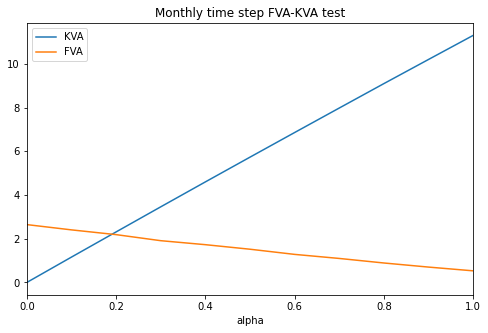

In [14]:
plt.figure(figsize=(8,5))
plt.plot(alpha, KVA_test, label = 'KVA')
plt.plot(alpha, FVA_test, label = 'FVA')
plt.legend(loc="upper left")
plt.title('Monthly time step FVA-KVA test')
plt.ylabel('')
plt.xlabel('alpha')
plt.xlim(0., 1.0) 
plt.show()

In [47]:
first_couple_calculator(first_couple_graph, nb_step= 5,
              sigma = 0.3, f = None, alpha = 1., 
              omega = np.array([0., 0., 0., 0., 1.]),
              K = np.array([110., 115., 120., 125., 107.]), max_iter = 200,
              verbose = 10)

iter =   0 | err = 0.0870
iter =  10 | err = 0.1537
iter =  20 | err = 0.0456
iter =  30 | err = 0.0114
iter =  40 | err = 0.0125
iter =  50 | err = 0.0014
iter =  60 | err = 0.0000
iter =  70 | err = 0.0001
iter =  80 | err = 0.0000
iter =  90 | err = 0.0000
iter = 100 | err = 0.0000
iter = 110 | err = 0.0000
iter = 120 | err = 0.0000
iter = 130 | err = 0.0000
iter = 140 | err = 0.0000
iter = 150 | err = 0.0000
iter = 160 | err = 0.0000
iter = 170 | err = 0.0000
iter = 180 | err = 0.0000
iter = 190 | err = 0.0000
iter = 200 | err = 0.0000
Fitted f = 0.8682


(1.0291265984863534, 8.241164308510639, 0.868216170821396)